In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Importing libraries
import numpy as np 
import pandas as pd
import os
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

# Initializing seed to maintain consistency
SEED = 661077
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Using various hyperparameters 
EPOCHS = 4
EPSILON = 1e-4
DEBUG = True 
LR = 0.01
MOMENTUM = 0.9

# Take cude if it is available
thisDevice = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(thisDevice)
print("The device in use is : "+thisDevice)

In [4]:
# Function for dataset class
class bookDataset(Dataset):
    def __init__(self,images_file,labels_file,dataDir,comp = False):
        # store the dataframe for the csv files
        
        self.images = pd.read_csv(os.path.join(dataDir,images_file))
        
        # comp part labels are not given
        self.comp = comp
        self.labels = None
        
        if not self.comp:
            self.labels = pd.read_csv(os.path.join(dataDir,labels_file))
        
        self.img_dir = os.path.join(dataDir,"images","images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.images.iloc[idx,1])
        thisImg = Image.open(img_path)
        thisTransform = transforms.Compose([transforms.PILToTensor()])
        img_tensor = thisTransform(thisImg)/255
        
        thisLab = -1
        if not self.comp:
            thisLab = self.labels.iloc[idx,1]
        return img_tensor,thisLab

# dataset & dataloaders initialization
trainDataset = bookDataset("train_x.csv","train_y.csv","/kaggle/input/col774-2022/")
testDataset = bookDataset("non_comp_test_x.csv","non_comp_test_y.csv","/kaggle/input/col774-2022/")
trainloader = DataLoader(trainDataset,batch_size = 64,shuffle = True)
testloader = DataLoader(testDataset,batch_size = 64,shuffle = True)

torch.Size([3, 224, 224])


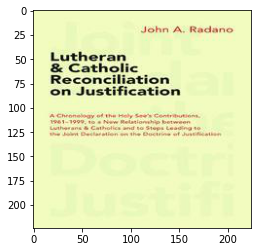

In [5]:
# visualization of data points
print(trainDataset[0][0].size())
plt.imshow(trainDataset[0][0].numpy().transpose(1, 2, 0))

In [6]:
# model class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,kernel_size = (5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),stride = 2),
            nn.Conv2d(32,64,kernel_size = (5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),stride = 2),
            nn.Conv2d(64,128,kernel_size = (5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),stride = 2))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*24*24,128),
            nn.ReLU(),
            nn.Linear(128,30))
        
    
    def forward(self,x):
        convOut = self.conv(x)
        fcOut = self.fc(convOut)
        return fcOut

model = CNNModel()

In [9]:
# defining the loss function and optimizer for the model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = LR,momentum = MOMENTUM)   

model = model.to(device)

# Testing on the test data
def calAccuracy(model,dataloader,device):
    correct = 0
    total = 0
    
    # no need to track the forward computation
    torch.set_grad_enabled(False)
    
    for data in dataloader:
        inputs,labels = data
        total += labels.size(0)
        
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        _,predicted = torch.max(model(inputs).data,1)
        correct += (predicted==labels).sum().item()
        
    torch.set_grad_enabled(True)
    finalAcc = (correct*100)/total
    print("The accuracy of the model : "+str(finalAcc))
    return finalAcc

The device in use is : cuda:0


In [10]:
# training model function
def trainModel(model,dataloader,loss_fn,optimizer,EPOCHS,EPSILON,device,PATH):
    
    last_loss = (np.inf)/2
    max_valAcc = 0
    
    for epoch in range(EPOCHS):
        this_loss = 0.0

        for idx,data in enumerate(dataloader,0):
            if(DEBUG and idx%100==0): print("Iteration : "+str(idx))
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            loss = loss_fn(model(inputs),labels)
            loss.backward()
            optimizer.step()

            this_loss += loss
        
        this_loss = this_loss/len(dataloader)
        #if(abs(this_loss-last_loss)<EPSILON): break
        last_loss = this_loss
        
        print("Epoch : "+str(epoch)+", Loss ==> "+str(last_loss))
        print("Testing Accuracy ==>")
        
        this_valAcc = calAccuracy(model,testloader,device)
        
        # Save the model only if validation accuracy is greater than previous max
        if(this_valAcc>max_valAcc):
            max_valAcc = this_valAcc
            torch.save(model.state_dict(),PATH)
            print("Model saved")
        
    return model

In [11]:
# Running the loop

PATH = "/kaggle/working/CNNModel.pth"
trainModel(model,trainloader,loss_fn,optimizer,EPOCHS,EPSILON,device,PATH)

Iteration : 0
Iteration : 100
Iteration : 200
Iteration : 300
Iteration : 400
Iteration : 500
Epoch : 0, Loss ==> tensor(3.3705, device='cuda:0', grad_fn=<DivBackward0>)
Testing Accuracy ==>
The accuracy of the model : 6.140350877192983
Model saved
Iteration : 0
Iteration : 100
Iteration : 200
Iteration : 300
Iteration : 400
Iteration : 500
Epoch : 1, Loss ==> tensor(3.2509, device='cuda:0', grad_fn=<DivBackward0>)
Testing Accuracy ==>
The accuracy of the model : 10.578947368421053
Model saved
Iteration : 0
Iteration : 100
Iteration : 200
Iteration : 300
Iteration : 400
Iteration : 500
Epoch : 2, Loss ==> tensor(3.1149, device='cuda:0', grad_fn=<DivBackward0>)
Testing Accuracy ==>
The accuracy of the model : 12.263157894736842
Model saved
Iteration : 0
Iteration : 100
Iteration : 200
Iteration : 300
Iteration : 400
Iteration : 500
Epoch : 3, Loss ==> tensor(2.9556, device='cuda:0', grad_fn=<DivBackward0>)
Testing Accuracy ==>
The accuracy of the model : 14.456140350877194
Model saved


CNNModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=73728, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=30, bias=True)
  )
)

In [14]:
# reloading the last saved(best) model
model = CNNModel()
model.load_state_dict(torch.load(PATH))
model.to(device)

print("Training Accuracy ==>"+str(calAccuracy(model,trainloader,device)))
print("Testing Accuracy ==>"+str(calAccuracy(model,testloader,device)))

Training Accuracy ==>
The accuracy of the model : 22.260233918128655
Testing Accuracy ==>
The accuracy of the model : 14.456140350877194


14.456140350877194

In [21]:
compDataset = bookDataset("comp_test_x.csv","trash","/kaggle/input/col774-2022/",comp = True)
comploader = DataLoader(compDataset,batch_size = 64,shuffle = False)

# printing the output dataframe to csv file
def outputToFile(model,dataloader,device,outFileName):
    torch.set_grad_enabled(False)
    
    counter = 0
    Ids = []
    outputs = []
    
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        _,predicted = torch.max(model(inputs).data,1)
        
        for pred in predicted:
            Ids.append(counter)
            outputs.append(int(pred))
            counter += 1
        
    torch.set_grad_enabled(True)
    df = pd.DataFrame(list(zip(Ids,outputs)),columns = ["Id","Genre"])
    df.to_csv(outFileName,index=False)

outputToFile(model,comploader,device,"/kaggle/working/CNN_submission.csv")